Disclaimer: I am very new to object detection so this isn't a great model. This is my first notebook on object detection too. I used this [notebook](https://www.kaggle.com/mattbast/object-detection-tensorflow-end-to-end#Evaluate-Model) heavily when creating this object detection model. Go check it out if you want. 

# **Import Libraries**

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import numpy as np 
import pandas as pd
import scipy
import glob
import time
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
# import ostwitter_data
import cv2
import shutil
import lxml
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageEnhance
# import albumentations as albu

# **Classification Model**

# **Create Dataframe from Images**

In [3]:
dirlist = ['../data/TBX11K/imgs/health', '../data/TBX11K/imgs/sick', '../data/TBX11K/imgs/tb']
classes = ['Healthy', 'Sick', 'Tuberculosis']
filepaths = []
labels = []
for d, c in zip(dirlist, classes):
    flist = os.listdir(d)
    for f in flist:
        fpath = os.path.join(d, f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  8400    labels:  8400


In [4]:
Fseries=pd.Series(filepaths, name='file_paths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)
df=pd.DataFrame(np.array(df).reshape(8400,2), columns = ['file_paths', 'labels'])
print(df['labels'].value_counts())

Healthy         3800
Sick            3800
Tuberculosis     800
Name: labels, dtype: int64


# **Balance Dataset**

In [5]:
file_count = 800
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (df['labels'].value_counts())
print (len(df))

Sick            800
Healthy         800
Tuberculosis    800
Name: labels, dtype: int64
2400


In [6]:
df.head()

,file_paths,labels
0,../data/TBX11K/imgs/sick/s0942.png,Sick
1,../data/TBX11K/imgs/health/h3600.png,Healthy
2,../data/TBX11K/imgs/sick/s2649.png,Sick
3,../data/TBX11K/imgs/tb/tb0125.png,Tuberculosis
4,../data/TBX11K/imgs/sick/s0337.png,Sick


# **Visualize Images**

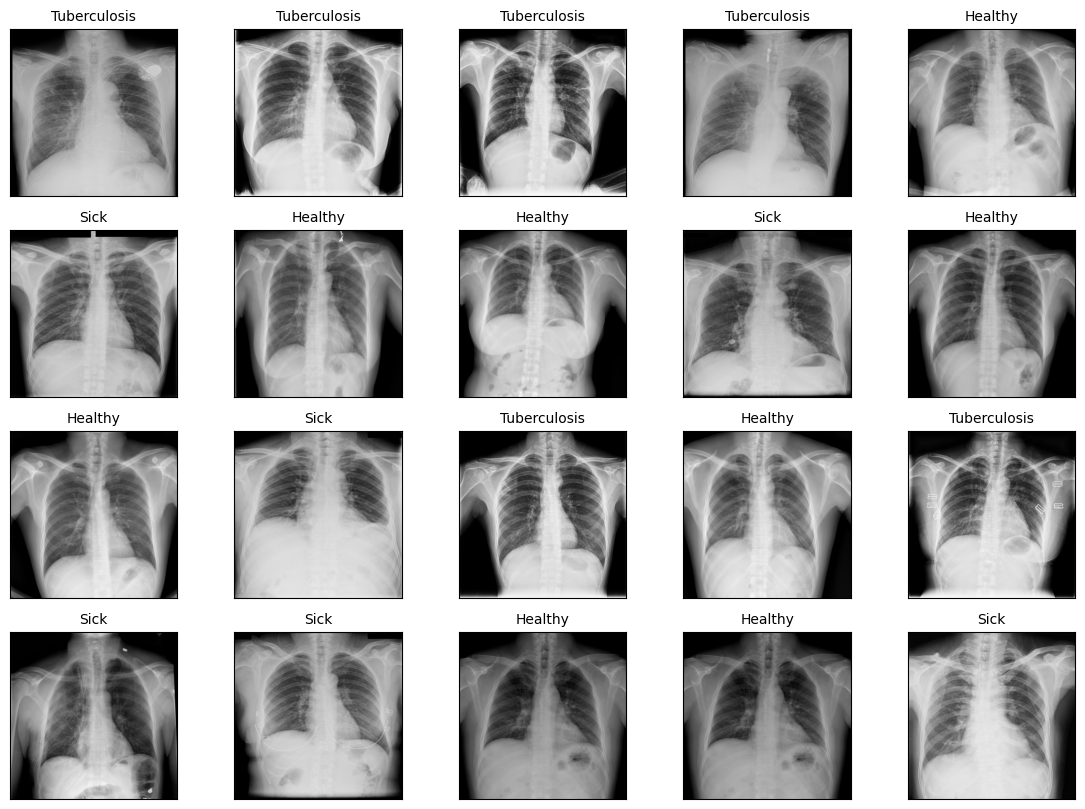

In [7]:
plt.figure(figsize=(14,10))
for i in range(20):
    random = np.random.randint(1,len(df))
    plt.subplot(4,5,i+1)
    img = df.loc[random,"file_paths"]
    plt.imshow(plt.imread(img))
    plt.title(df.loc[random, "labels"], size = 10, color = "black") 
    plt.xticks([])
    plt.yticks([])

    
plt.show()

Looks like we can do horizontal flips with ImageDataGenerator.

# **Split Dataframe into Train, Valid, and Test**

In [8]:
train_df, test_df = train_test_split(df, train_size=0.95, random_state=0)
train_df, valid_df = train_test_split(train_df, train_size=0.9, random_state=0)
print(train_df.labels.value_counts())
print(valid_df.labels.value_counts())
print(test_df.labels.value_counts())

Tuberculosis    685
Sick            684
Healthy         683
Name: labels, dtype: int64
Sick            79
Healthy         79
Tuberculosis    70
Name: labels, dtype: int64
Tuberculosis    45
Healthy         38
Sick            37
Name: labels, dtype: int64


# **ImageDataGenerator**

In [9]:
target_size=(224,224)
batch_size=16

In [10]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input, horizontal_flip=True)
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
    
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, 
    color_mode='rgb', class_mode='categorical')
valid_gen = test_datagen.flow_from_dataframe(
    valid_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, 
    color_mode='rgb', class_mode='categorical')
test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, 
    color_mode='rgb', class_mode='categorical')

Found 2052 validated image filenames belonging to 3 classes.
Found 228 validated image filenames belonging to 3 classes.
Found 120 validated image filenames belonging to 3 classes.


# **EfficientNetB7 Model**

In [11]:
base_model = tf.keras.applications.EfficientNetB7(include_top=False, input_shape=(224,224,3), weights='imagenet')
classify_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(3, activation='softmax')
])

In [12]:
lr=0.001
classify_model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(lr=lr), 
    metrics=['accuracy'])

/Users/user/projects/TB/bounding-box-lung-disease-detection/env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# **Custom Callbacks**

In [13]:
patience = 2
stop_patience = 5
factor = 0.5

callbacks = [ 
    tf.keras.callbacks.ModelCheckpoint(
        "classify_model.h5", monitor='val_loss', save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(
        patience=stop_patience, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=factor, patience=patience, verbose=1)
]

# **Training**

In [14]:
epochs = 30
history = classify_model.fit(train_gen, 
    validation_data=valid_gen, 
    epochs=epochs, 
    callbacks=callbacks, 
    verbose=1)

Epoch 1/30


2023-02-20 09:10:17.468156: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


129/129 [==============================] - 1287s 10s/step - loss: 0.3941 - accuracy: 0.8748 - val_loss: 1.4665 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 2/30
129/129 [==============================] - 1150s 9s/step - loss: 0.2212 - accuracy: 0.9279 - val_loss: 0.8147 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 3/30
129/129 [==============================] - 1249s 10s/step - loss: 0.2275 - accuracy: 0.9298 - val_loss: 0.1570 - val_accuracy: 0.9518 - lr: 0.0010
Epoch 4/30
129/129 [==============================] - 1233s 10s/step - loss: 0.1418 - accuracy: 0.9547 - val_loss: 0.1367 - val_accuracy: 0.9693 - lr: 0.0010
Epoch 5/30
  6/129 [>.............................] - ETA: 19:47 - loss: 0.1180 - accuracy: 0.9479

KeyboardInterrupt: 

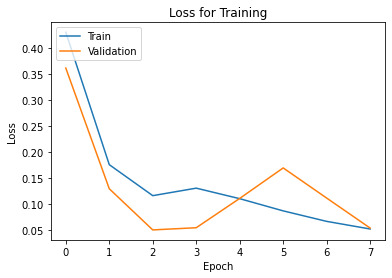

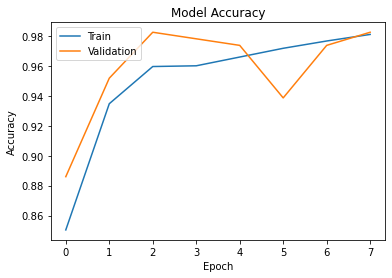

In [ ]:
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc="upper left")
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
best_model = classify_model
best_model.load_weights('./classify_model.h5')
best_model.evaluate(test_gen)

8/8 [==============================] - 9s 1s/step - loss: 0.0679 - accuracy: 0.9750


[0.06788701564073563, 0.9750000238418579]

# **Object Detection Model**

# **Create Dataframe with Bound Boxes**

In [ ]:
def create_boundbox_df(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
    bbox_df = pd.DataFrame(xml_list, columns=column_name)
    return bbox_df

bbox_df = create_boundbox_df('../input/tbx-11/TBX11K/annotations/xml')
bbox_df.head()

,filename,width,height,xmin,ymin,xmax,ymax
0,tb0750,1862,2022,473,400,834,895
1,tb0500,2372,2880,1421,512,2059,1397
2,tb0500,2372,2880,617,555,1173,1315
3,tb0532,1787,2022,188,709,497,920
4,tb1104,1754,2022,154,515,718,1061


# **Reshape Bounding Boxes into COCO**

In [ ]:
width_ratio = 256 / bbox_df.width
height_ratio = 256 / bbox_df.height
width_ratio = width_ratio.rename('width_ratio')
height_ratio = height_ratio.rename('height_ratio')
bbox_df = pd.concat([bbox_df, width_ratio, height_ratio], axis=1)
bbox_df.head()

,filename,width,height,xmin,ymin,xmax,ymax,width_ratio,height_ratio
0,tb0750,1862,2022,473,400,834,895,0.137487,0.126607
1,tb0500,2372,2880,1421,512,2059,1397,0.107926,0.088889
2,tb0500,2372,2880,617,555,1173,1315,0.107926,0.088889
3,tb0532,1787,2022,188,709,497,920,0.143257,0.126607
4,tb1104,1754,2022,154,515,718,1061,0.145952,0.126607


In [ ]:
true_xmin = bbox_df.xmin * bbox_df.width_ratio
true_ymin = bbox_df.ymin * bbox_df.height_ratio
true_width = (bbox_df.xmax - bbox_df.xmin) * bbox_df.width_ratio
true_height = (bbox_df.ymax - bbox_df.ymin) * bbox_df.height_ratio
true_xmin = true_xmin.rename('true_xmin')
true_ymin = true_ymin.rename('true_ymin')
true_width = true_width.rename('true_width')
true_height = true_height.rename('true_height')
bbox_df = pd.concat([bbox_df, true_xmin, true_ymin, true_width, true_height], axis=1)
bbox_df.head()

,filename,width,height,xmin,ymin,xmax,ymax,width_ratio,height_ratio,true_xmin,true_ymin,true_width,true_height
0,tb0750,1862,2022,473,400,834,895,0.137487,0.126607,65.031149,50.642928,49.632653,62.670623
1,tb0500,2372,2880,1421,512,2059,1397,0.107926,0.088889,153.362563,45.511111,68.856661,78.666667
2,tb0500,2372,2880,617,555,1173,1315,0.107926,0.088889,66.590219,49.333333,60.006745,67.555556
3,tb0532,1787,2022,188,709,497,920,0.143257,0.126607,26.932289,89.764590,44.266368,26.714144
4,tb1104,1754,2022,154,515,718,1061,0.145952,0.126607,22.476625,65.202770,82.316990,69.127596


In [ ]:
bbox_df = bbox_df.round(2)
bbox_df.head()

,filename,width,height,xmin,ymin,xmax,ymax,width_ratio,height_ratio,true_xmin,true_ymin,true_width,true_height
0,tb0750,1862,2022,473,400,834,895,0.14,0.13,65.03,50.64,49.63,62.67
1,tb0500,2372,2880,1421,512,2059,1397,0.11,0.09,153.36,45.51,68.86,78.67
2,tb0500,2372,2880,617,555,1173,1315,0.11,0.09,66.59,49.33,60.01,67.56
3,tb0532,1787,2022,188,709,497,920,0.14,0.13,26.93,89.76,44.27,26.71
4,tb1104,1754,2022,154,515,718,1061,0.15,0.13,22.48,65.20,82.32,69.13


In [ ]:
bbox = []
for i in range(len(bbox_df)):
    x = bbox_df.iloc[i, 9]
    y = bbox_df.iloc[i, 10]
    w = bbox_df.iloc[i, 11]
    h = bbox_df.iloc[i, 12]
    bbox.append([x, y, w, h])
bbox = pd.Series(bbox)
bbox = bbox.rename('bbox')
bbox_df = pd.concat([bbox_df, bbox], axis=1)
bbox_df.head()

,filename,width,height,xmin,ymin,xmax,ymax,width_ratio,height_ratio,true_xmin,true_ymin,true_width,true_height,bbox
0,tb0750,1862,2022,473,400,834,895,0.14,0.13,65.03,50.64,49.63,62.67,"[65.03, 50.64, 49.63, 62.67]"
1,tb0500,2372,2880,1421,512,2059,1397,0.11,0.09,153.36,45.51,68.86,78.67,"[153.36, 45.51, 68.86, 78.67]"
2,tb0500,2372,2880,617,555,1173,1315,0.11,0.09,66.59,49.33,60.01,67.56,"[66.59, 49.33, 60.01, 67.56]"
3,tb0532,1787,2022,188,709,497,920,0.14,0.13,26.93,89.76,44.27,26.71,"[26.93, 89.76, 44.27, 26.71]"
4,tb1104,1754,2022,154,515,718,1061,0.15,0.13,22.48,65.20,82.32,69.13,"[22.48, 65.2, 82.32, 69.13]"


In [ ]:
annots_df = pd.concat([bbox_df.filename, bbox_df.bbox], axis=1)
annots_df.head()

,filename,bbox
0,tb0750,"[65.03, 50.64, 49.63, 62.67]"
1,tb0500,"[153.36, 45.51, 68.86, 78.67]"
2,tb0500,"[66.59, 49.33, 60.01, 67.56]"
3,tb0532,"[26.93, 89.76, 44.27, 26.71]"
4,tb1104,"[22.48, 65.2, 82.32, 69.13]"


# **Organize Bounding Boxes by Filename**

In [ ]:
def bboxOnly(group):
    return group['bbox']

labels = annots_df.groupby('filename').apply(bboxOnly)
labels.head()

filename     
tb0003    949    [130.34, 22.64, 50.57, 69.46]
          950     [55.71, 35.41, 50.39, 56.33]
tb0004    722     [64.83, 28.87, 58.19, 47.48]
          723     [162.7, 40.13, 45.06, 52.04]
tb0005    953    [191.42, 63.94, 20.12, 22.28]
Name: bbox, dtype: object

In [ ]:
def aggregator(filename):
    bbox_list = []
    for i in range(labels[filename].size):
        bbox_list.append(labels[filename].values[i])
    return bbox_list

In [ ]:
bboxes = []
files = []
for f in annots_df.filename:
    bboxes.append(aggregator(f))
    files.append(f)

In [ ]:
Fseries=pd.Series(files, name='file_id')
Lseries=pd.Series(bboxes, name='bbox')
image_annots_df=pd.concat([Fseries,Lseries], axis=1)
image_annots_df=pd.DataFrame(np.array(image_annots_df).reshape(1211,2), columns = ['file_id', 'bbox'])
image_annots_df = image_annots_df.drop_duplicates(subset ="file_id")
image_annots_df.head()

,file_id,bbox
0,tb0750,"[[65.03, 50.64, 49.63, 62.67]]"
1,tb0500,"[[153.36, 45.51, 68.86, 78.67], [66.59, 49.33,..."
3,tb0532,"[[26.93, 89.76, 44.27, 26.71]]"
4,tb1104,"[[22.48, 65.2, 82.32, 69.13], [180.69, 69.38, ..."
6,tb1113,"[[145.09, 25.28, 51.66, 42.57]]"


In [ ]:
image_annots_df = image_annots_df.set_index('file_id')
image_annots_df.head()

,bbox
file_id,
tb0750,"[[65.03, 50.64, 49.63, 62.67]]"
tb0500,"[[153.36, 45.51, 68.86, 78.67], [66.59, 49.33,..."
tb0532,"[[26.93, 89.76, 44.27, 26.71]]"
tb1104,"[[22.48, 65.2, 82.32, 69.13], [180.69, 69.38, ..."
tb1113,"[[145.09, 25.28, 51.66, 42.57]]"


# **Split Bounding Boxes into Train, Valid, and Test**

In [ ]:
train_image_ids = np.unique(image_annots_df.index.values)[0:780]
val_image_ids = np.unique(image_annots_df.index.values)[780:799]

# **Load Tuberculosis Images**

In [ ]:
def load_image(image_id):
    image = Image.open('../input/tbx-11/TBX11K/imgs/tb/' + image_id + ".png")
    image = image.resize((256, 256))
    
    return np.asarray(image)

In [ ]:
train_pixels = {}
train_labels = {}

for image_id in train_image_ids:
    train_pixels[image_id] = load_image(image_id)
    train_labels[image_id] = image_annots_df.loc[image_id, 'bbox'].copy()

val_pixels = {}
val_labels = {}

for image_id in val_image_ids:
    val_pixels[image_id] = load_image(image_id)    
    val_labels[image_id] = image_annots_df.loc[image_id, 'bbox'].copy()

In [ ]:
for bbox in train_labels['tb0500']:
    print(bbox)

[153.36, 45.51, 68.86, 78.67]
[66.59, 49.33, 60.01, 67.56]


# **Visualize Images with Bounding Boxes**

In [ ]:
def draw_bboxes(image_id, bboxes, source='train'):  
    image = Image.open('../input/tbx-11/TBX11K/imgs/tb/'+ image_id + ".png")
    image = image.resize((256,256))
    
    draw = ImageDraw.Draw(image)
            
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    
    return np.asarray(image)


def draw_bbox(draw, bbox):
    xmin, ymin, width, height = bbox
    xmin = xmin
    ymin = ymin
    xmax = xmin + width
    ymax = ymin + height
    draw.rectangle([xmin, ymin, xmax, ymax], width=2, outline='red')
    
def show_images(image_ids, bboxes, source='train'):
    pixels = []
    
    for image_id in image_ids:
        pixels.append(
            draw_bboxes(image_id, bboxes[image_id], source)
        )
    
    num_of_images = len(image_ids)
    fig, axes = plt.subplots(
        1, 
        num_of_images, 
        figsize=(5 * num_of_images, 5 * num_of_images)
    )
    
    for i, image_pixels in enumerate(pixels):
        axes[i].imshow(image_pixels)

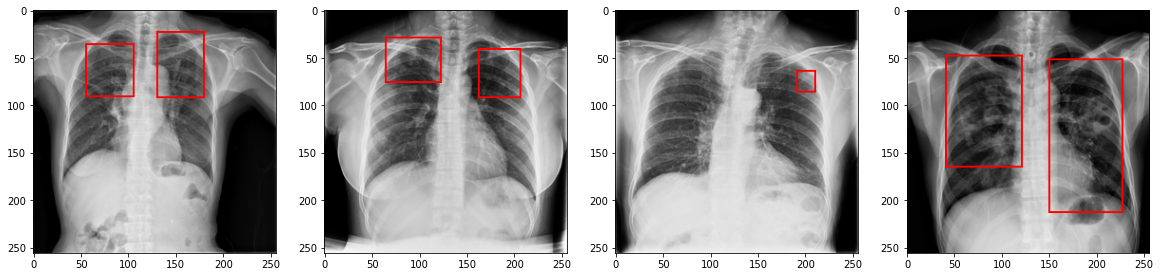

In [ ]:
show_images(train_image_ids[0:4], train_labels)

# **Create Custom Data Pipeline**

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, image_ids, image_pixels, labels=None, batch_size=1, shuffle=False, augment=False):
        self.image_ids = image_ids
        self.image_pixels = image_pixels
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
        self.image_grid = self.form_image_grid()
        
        
    def form_image_grid(self):    
        image_grid = np.zeros((32, 32, 4))

        # x, y, width, height
        cell = [0, 0, 256 / 32, 256 / 32] 

        for i in range(0, 32):
            for j in range(0, 32):
                image_grid[i,j] = cell

                cell[0] = cell[0] + cell[2]

            cell[0] = 0
            cell[1] = cell[1] + cell[3]

        return image_grid

def __len__(self):
    return int(np.floor(len(self.image_ids) / self.batch_size))


def on_epoch_end(self):
    self.indexes = np.arange(len(self.image_ids))

    if self.shuffle == True:
        np.random.shuffle(self.indexes)


DataGenerator.__len__ = __len__
DataGenerator.on_epoch_end = on_epoch_end

In [ ]:
DataGenerator.train_augmentations = albu.Compose([
        albu.HorizontalFlip(always_apply=False, p=0.5),
#         albu.CLAHE(p=1),
        albu.ToGray(p=1)
    ], 
    bbox_params={'format': 'coco', 'label_fields': ['labels']})

DataGenerator.val_augmentations = albu.Compose([
#     albu.CLAHE(p=1),
    albu.ToGray(p=1)
])

In [ ]:
def __getitem__(self, index):
    indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

    batch_ids = [self.image_ids[i] for i in indexes]

    X, y = self.__data_generation(batch_ids)

    return X, y


def __data_generation(self, batch_ids):
    X, y = [], []

    # Generate data
    for i, image_id in enumerate(batch_ids):
        pixels = self.image_pixels[image_id]
        bboxes = self.labels[image_id]

        if self.augment:     
            pixels, bboxes = self.augment_image(pixels, bboxes)
        else:
            pixels = self.contrast_image(pixels)
            bboxes = self.form_label_grid(bboxes)

        X.append(pixels)
        y.append(bboxes)

    return np.array(X), np.array(y)


def augment_image(self, pixels, bboxes):
    bbox_labels = np.ones(len(bboxes))

    aug_result = self.train_augmentations(image=pixels, bboxes=bboxes, labels=bbox_labels)

    bboxes = self.form_label_grid(aug_result['bboxes'])

    return np.array(aug_result['image']) / 255, bboxes


def contrast_image(self, pixels):        
    aug_result = self.val_augmentations(image=pixels)
    return np.array(aug_result['image']) / 255


DataGenerator.__getitem__ = __getitem__
DataGenerator.__data_generation = __data_generation
DataGenerator.augment_image = augment_image
DataGenerator.contrast_image = contrast_image

In [ ]:
def form_label_grid(self, bboxes):
    label_grid = np.zeros((32, 32, 10))

    for i in range(0, 32):
        for j in range(0, 32):
            cell = self.image_grid[i,j]
            label_grid[i,j] = self.rect_intersect(cell, bboxes)

    return label_grid


def rect_intersect(self, cell, bboxes): 
    cell_x, cell_y, cell_width, cell_height = cell
    cell_x_max = cell_x + cell_width 
    cell_y_max = cell_y + cell_height
    
    anchor_one = np.array([0, 0, 0, 0, 0])
    anchor_two = np.array([0, 0, 0, 0, 0])

    # check all boxes
    for bbox in bboxes:
        box_x, box_y, box_width, box_height = bbox
        box_x_centre = box_x + (box_width / 2)
        box_y_centre = box_y + (box_height / 2)

        if(box_x_centre >= cell_x and box_x_centre < cell_x_max and box_y_centre >= cell_y and box_y_centre < cell_y_max):
            
            if anchor_one[0] == 0:
                anchor_one = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
            
            elif anchor_two[0] == 0:
                anchor_two = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
                
            else:
                break

    return np.concatenate((anchor_one, anchor_two), axis=None)


def yolo_shape(self, box, cell):
    box_x, box_y, box_width, box_height = box
    cell_x, cell_y, cell_width, cell_height = cell

    # top left x,y to centre x,y
    box_x = box_x + (box_width / 2)
    box_y = box_y + (box_height / 2)

    # offset bbox x,y to cell x,y
    box_x = (box_x - cell_x) / cell_width
    box_y = (box_y - cell_y) / cell_height

    # bbox width,height relative to cell width,height
    box_width = box_width / 256
    box_height = box_height / 256

    return [1, box_x, box_y, box_width, box_height]


DataGenerator.form_label_grid = form_label_grid
DataGenerator.rect_intersect = rect_intersect
DataGenerator.yolo_shape = yolo_shape

In [ ]:
train_generator = DataGenerator(
    train_image_ids,
    train_pixels,
    train_labels, 
    batch_size=6, 
    shuffle=True,
    augment=True
)

val_generator = DataGenerator(
    val_image_ids, 
    val_pixels,
    val_labels, 
    batch_size=10,
    shuffle=False,
    augment=True
)

image_grid = train_generator.image_grid

# **Model Architecture**

In [ ]:
x_input = tf.keras.Input(shape=(256,256,3))

x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

########## block 1 ##########
x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x


########## block 2 ##########
x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 3 ##########
x = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

    
########## block 4 ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 5 ##########
x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(4):
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## output layers ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

predictions = tf.keras.layers.Conv2D(10, (1, 1), strides=(1, 1), activation='sigmoid')(x)

object_detection_model = tf.keras.Model(inputs=x_input, outputs=predictions)

# **Create Custom Loss**

In [ ]:
def custom_loss(y_true, y_pred):
    binary_crossentropy = prob_loss = tf.keras.losses.BinaryCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    
    prob_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,0], y_true[:,:,:,5]], axis=0), 
        tf.concat([y_pred[:,:,:,0], y_pred[:,:,:,5]], axis=0)
    )
    
    xy_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,1:3], y_true[:,:,:,6:8]], axis=0), 
        tf.concat([y_pred[:,:,:,1:3], y_pred[:,:,:,6:8]], axis=0)
    )
    
    wh_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,3:5], y_true[:,:,:,8:10]], axis=0), 
        tf.concat([y_pred[:,:,:,3:5], y_pred[:,:,:,8:10]], axis=0)
    )
    
    bboxes_mask = get_mask(y_true)
    
    xy_loss = xy_loss * bboxes_mask
    wh_loss = wh_loss * bboxes_mask
    
    return prob_loss + xy_loss + wh_loss


def get_mask(y_true):
    anchor_one_mask = tf.where(
        y_true[:,:,:,0] == 0, 
        0.5, 
        5.0
    )
    
    anchor_two_mask = tf.where(
        y_true[:,:,:,5] == 0, 
        0.5, 
        5.0
    )
    
    bboxes_mask = tf.concat(
        [anchor_one_mask,anchor_two_mask],
        axis=0
    )
    
    return bboxes_mask

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

object_detection_model.compile(
    optimizer=optimizer, 
    loss=custom_loss
)

# **Callbacks**

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath='./object_detection_model.h5', save_best_only=True)
]

# **Model Training**

In [ ]:
object_detection_history = object_detection_model.fit(train_generator, validation_data=val_generator, epochs=80, callbacks=callbacks)

Epoch 1/80
130/130 [==============================] - 114s 818ms/step - loss: 0.3501 - val_loss: 0.0607
Epoch 2/80
130/130 [==============================] - 104s 801ms/step - loss: 0.0150 - val_loss: 0.0164
Epoch 3/80
130/130 [==============================] - 104s 801ms/step - loss: 0.0089 - val_loss: 0.0106
Epoch 4/80
130/130 [==============================] - 104s 801ms/step - loss: 0.0071 - val_loss: 0.0077
Epoch 5/80
130/130 [==============================] - 104s 801ms/step - loss: 0.0062 - val_loss: 0.0074
Epoch 6/80
130/130 [==============================] - 104s 801ms/step - loss: 0.0056 - val_loss: 0.0080
Epoch 7/80
130/130 [==============================] - 104s 802ms/step - loss: 0.0053 - val_loss: 0.0060
Epoch 8/80
130/130 [==============================] - 104s 801ms/step - loss: 0.0053 - val_loss: 0.0061
Epoch 9/80
130/130 [==============================] - 104s 800ms/step - loss: 0.0051 - val_loss: 0.0099

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0005

In [ ]:
plt.plot(object_detection_history.history['loss'], label='Loss (training data)')
plt.plot(object_detection_history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc="upper left")
plt.show()

NameError: name 'object_detection_history' is not defined

# **Prediction Post Processing**

In [ ]:
def prediction_to_bbox(bboxes, image_grid):    
    bboxes = bboxes.copy()
    
    im_width = (image_grid[:,:,2] * 32)
    im_height = (image_grid[:,:,3] * 32)
    
    # descale x,y
    bboxes[:,:,1] = (bboxes[:,:,1] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,2] = (bboxes[:,:,2] * image_grid[:,:,3]) + image_grid[:,:,1]
    bboxes[:,:,6] = (bboxes[:,:,6] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,7] = (bboxes[:,:,7] * image_grid[:,:,3]) + image_grid[:,:,1]
    
    # descale width,height
    bboxes[:,:,3] = bboxes[:,:,3] * im_width 
    bboxes[:,:,4] = bboxes[:,:,4] * im_height
    bboxes[:,:,8] = bboxes[:,:,8] * im_width 
    bboxes[:,:,9] = bboxes[:,:,9] * im_height
    
    # centre x,y to top left x,y
    bboxes[:,:,1] = bboxes[:,:,1] - (bboxes[:,:,3] / 2)
    bboxes[:,:,2] = bboxes[:,:,2] - (bboxes[:,:,4] / 2)
    bboxes[:,:,6] = bboxes[:,:,6] - (bboxes[:,:,8] / 2)
    bboxes[:,:,7] = bboxes[:,:,7] - (bboxes[:,:,9] / 2)
    
    # width,heigth to x_max,y_max
    bboxes[:,:,3] = bboxes[:,:,1] + bboxes[:,:,3]
    bboxes[:,:,4] = bboxes[:,:,2] + bboxes[:,:,4]
    bboxes[:,:,8] = bboxes[:,:,6] + bboxes[:,:,8]
    bboxes[:,:,9] = bboxes[:,:,7] + bboxes[:,:,9]
    
    return bboxes

def non_max_suppression(predictions, top_n):
    probabilities = np.concatenate((predictions[:,:,0].flatten(), predictions[:,:,5].flatten()), axis=None)
    
    first_anchors = predictions[:,:,1:5].reshape((32*32, 4))
    second_anchors = predictions[:,:,6:10].reshape((32*32, 4))
    
    bboxes = np.concatenate(
        (first_anchors,second_anchors),
        axis=0
    )
    
    bboxes = switch_x_y(bboxes)
    bboxes, probabilities = select_top(probabilities, bboxes, top_n=top_n)
    bboxes = switch_x_y(bboxes)
    
    return bboxes


def switch_x_y(bboxes):
    x1 = bboxes[:,0].copy()
    y1 = bboxes[:,1].copy()
    x2 = bboxes[:,2].copy()
    y2 = bboxes[:,3].copy()
    
    bboxes[:,0] = y1
    bboxes[:,1] = x1
    bboxes[:,2] = y2
    bboxes[:,3] = x2
    
    return bboxes


def select_top(probabilities, boxes, top_n=10):
    top_indices = tf.image.non_max_suppression(
        boxes = boxes, 
        scores = probabilities, 
        max_output_size = top_n, 
        iou_threshold = 0.3,
        score_threshold = 0.3
    )
    
    top_indices = top_indices.numpy()
    
    return boxes[top_indices], probabilities[top_indices]

def process_predictions(predictions, image_ids, image_grid):
    bboxes = {}
    
    for i, image_id in enumerate(image_ids[:10]):
        predictions[i] = prediction_to_bbox(predictions[i], image_grid)
        bboxes[image_id] = non_max_suppression(predictions[i], top_n=100)
        
        # back to coco shape
        bboxes[image_id][:,2:4] = bboxes[image_id][:,2:4] - bboxes[image_id][:,0:2]
    
    return bboxes

# **Visualizations of Predictions on Validation Dataset**

In [ ]:
val_predictions = object_detection_model.predict(val_generator)
val_predictions = process_predictions(val_predictions, val_image_ids, image_grid)

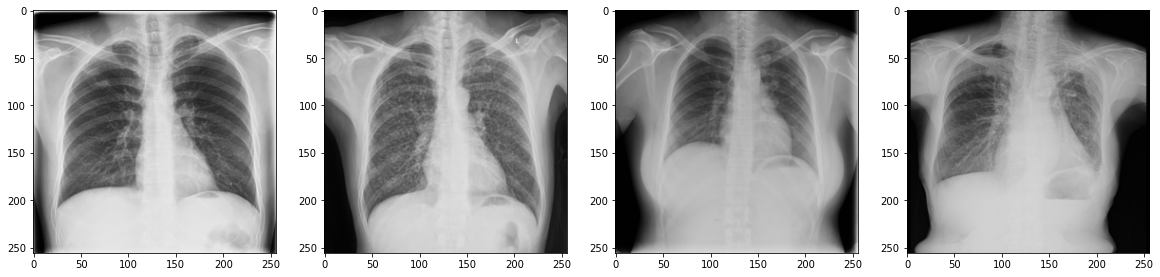

In [ ]:
show_images(val_image_ids[0:4], val_predictions)

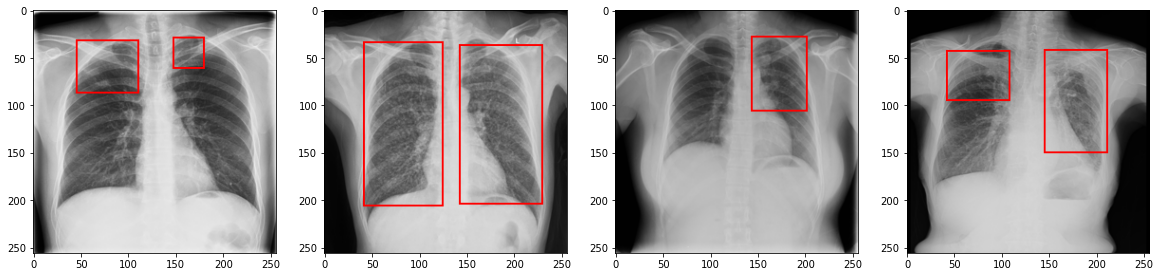

In [ ]:
show_images(val_image_ids[0:4], val_labels)

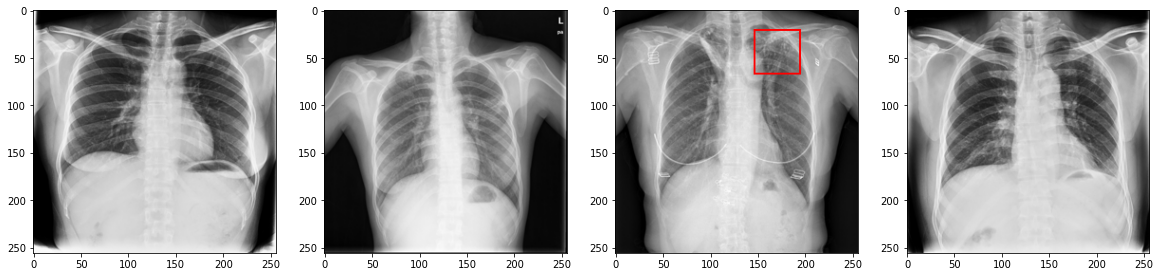

In [ ]:
show_images(val_image_ids[4:8], val_predictions)

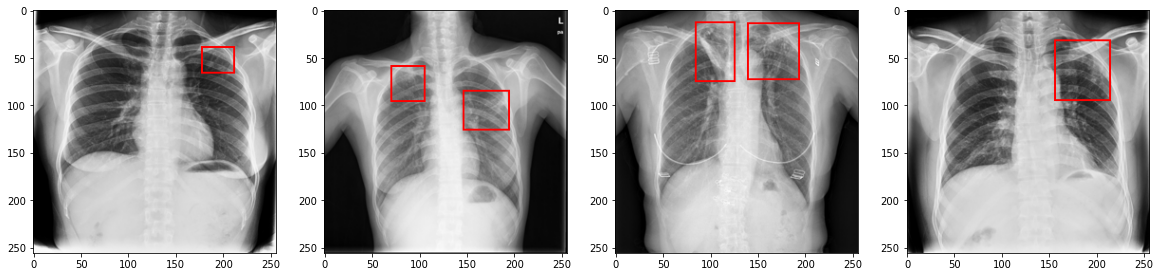

In [ ]:
show_images(val_image_ids[4:8], val_labels)

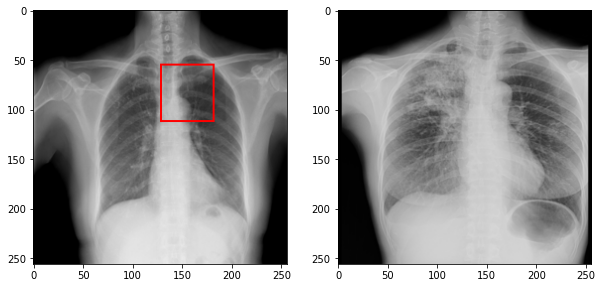

In [ ]:
show_images(val_image_ids[8:10], val_predictions)

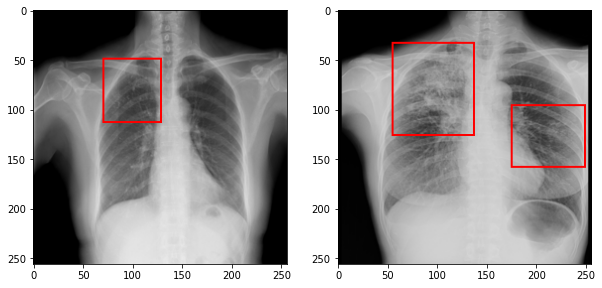

In [ ]:
show_images(val_image_ids[8:10], val_labels)

As we can see, the object detection model doesn't detect bounding boxes too well. 